In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/musicgenreclassification/features_3_sec.csv
/kaggle/input/musicgenreclassification/features_30_sec.csv
/kaggle/input/musicgenreclassification/images_waveplot/disco/disco00005.png
/kaggle/input/musicgenreclassification/images_waveplot/disco/disco00057.png
/kaggle/input/musicgenreclassification/images_waveplot/disco/disco00020.png
/kaggle/input/musicgenreclassification/images_waveplot/disco/disco00072.png
/kaggle/input/musicgenreclassification/images_waveplot/disco/disco00040.png
/kaggle/input/musicgenreclassification/images_waveplot/disco/disco00043.png
/kaggle/input/musicgenreclassification/images_waveplot/disco/disco00010.png
/kaggle/input/musicgenreclassification/images_waveplot/disco/disco00071.png
/kaggle/input/musicgenreclassification/images_waveplot/disco/disco00030.png
/kaggle/input/musicgenreclassification/images_waveplot/disco/disco00086.png
/kaggle/input/musicgenreclassification/images_waveplot/disco/disco00034.png
/kaggle/input/musicgenreclassification/images_w

In [34]:
# Music Genre Classification using Raw Waveform and Pretrained Models
# For Kaggle environment
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm
from transformers import Wav2Vec2Model, Wav2Vec2Config

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [35]:
# Configure paths for the Kaggle environment
DATA_PATH = "/kaggle/input/musicgenreclassification/genres_original"

# Create genre mapping from folder names
genre_folders = [d for d in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, d))]
genre_mapping = {genre: idx for idx, genre in enumerate(sorted(genre_folders))}
num_genres = len(genre_mapping)
print(f"Found {num_genres} genres: {genre_mapping}")

Found 10 genres: {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


In [36]:
# Check the problematic file
problematic_file = "/kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav"

# Try to load and examine the file
try:
    waveform, sr = torchaudio.load(problematic_file)
    print(f"File loaded successfully:")
    print(f"Sample rate: {sr}")
    print(f"Waveform shape: {waveform.shape}")
    print(f"Min value: {waveform.min()}")
    print(f"Max value: {waveform.max()}")
    
    # Plot the waveform
    plt.figure(figsize=(12, 4))
    plt.plot(waveform[0])
    plt.title("Waveform of jazz.00054.wav")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.show()
    
except Exception as e:
    print(f"Error loading file: {e}")
    print("This confirms the file is indeed corrupted")

Error loading file: Failed to open the input "/kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav" (Invalid data found when processing input).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7a52ff4b9446 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7a52ff4636e4 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42134 (0x7a52b34ca134 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::optional<std::map<std::string, std::string, std::less<std::string>, std::allocator<

In [37]:
# Count files by genre
genre_counts = {}
problem_files = []

for genre in genre_mapping.keys():
    genre_path = os.path.join(DATA_PATH, genre)
    if os.path.isdir(genre_path):
        files = [f for f in os.listdir(genre_path) if f.endswith('.wav') or f.endswith('.au')]
        genre_counts[genre] = len(files)
        
        # Try to load each file to find any other problematic ones
        for fname in files:
            file_path = os.path.join(genre_path, fname)
            try:
                waveform, sr = torchaudio.load(file_path)
            except Exception as e:
                problem_files.append((file_path, str(e)))

print("Files per genre:")
for genre, count in genre_counts.items():
    print(f"{genre}: {count}")

print("\nProblematic files found:")
for file_path, error in problem_files:
    print(f"{file_path}: {error}")

Files per genre:
blues: 100
classical: 100
country: 100
disco: 100
hiphop: 100
jazz: 100
metal: 100
pop: 100
reggae: 100
rock: 100

Problematic files found:
/kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav: Failed to open the input "/kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav" (Invalid data found when processing input).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7a52ff4b9446 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7a52ff4636e4 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42134 (0x7a52b34ca134 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.

In [38]:
# Audio Dataset Class
class AudioGenreDataset(Dataset):
    def __init__(self, audio_files, labels, sample_rate=16000, duration=3.0, transform=None):
        self.audio_files = audio_files
        self.labels = labels
        self.sample_rate = sample_rate
        self.max_length = int(duration * sample_rate)  # Convert duration to samples
        self.transform = transform
        
    def __len__(self):
        return len(self.audio_files)
    
    def __getitem__(self, idx):
        # Load audio file
        try:
            waveform, sr = torchaudio.load(self.audio_files[idx])
            
            # Convert to mono if stereo
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)
            
            # Resample if necessary
            if sr != self.sample_rate:
                resampler = torchaudio.transforms.Resample(sr, self.sample_rate)
                waveform = resampler(waveform)
            
            # Ensure consistent length
            if waveform.shape[1] < self.max_length:
                # Pad if too short
                padding = torch.zeros(1, self.max_length - waveform.shape[1])
                waveform = torch.cat([waveform, padding], dim=1)
            else:
                # Random crop if too long for training variety
                start = torch.randint(0, waveform.shape[1] - self.max_length + 1, (1,))
                waveform = waveform[:, start:start + self.max_length]
            
            # Apply transforms if provided
            if self.transform:
                waveform = self.transform(waveform)
                
            return waveform.squeeze(0), self.labels[idx]
        
        except Exception as e:
            print(f"Error loading {self.audio_files[idx]}: {e}")
            # Return zeros as a fallback
            return torch.zeros(self.max_length), self.labels[idx]

In [39]:
# Model Architecture using a pretrained model for raw waveform processing
class WaveformGenreClassifier(nn.Module):
    def __init__(self, pretrained_model_name="facebook/wav2vec2-base", num_genres=10, freeze_feature_extractor=True):
        super().__init__()
        
        # Load the pretrained model
        try:
            self.encoder = Wav2Vec2Model.from_pretrained(pretrained_model_name)
        except Exception as e:
            print(f"Error loading pretrained model: {e}")
            print("Initializing from config instead...")
            config = Wav2Vec2Config.from_pretrained(pretrained_model_name)
            self.encoder = Wav2Vec2Model(config)
        
        # Freeze the feature extractor if requested
        if freeze_feature_extractor:
            for param in self.encoder.parameters():
                param.requires_grad = False
        
        # Get the dimension of the encoder's output
        encoder_dim = self.encoder.config.hidden_size  # 768 for wav2vec2-base
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(encoder_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_genres)
        )
    
    def forward(self, x):
        # Wav2Vec2 expects inputs of shape [batch_size, sequence_length]
        # Extract features from the encoder
        features = self.encoder(x).last_hidden_state  # [batch_size, sequence_length, hidden_size]
        
        # Global pooling over the sequence length
        pooled = torch.mean(features, dim=1)  # [batch_size, hidden_size]
        
        # Classification
        output = self.classifier(pooled)
        return output

In [40]:
# Data preparation function
def prepare_dataset():
    all_files = []
    all_labels = []
    
    # Walk through the dataset directory
    for genre in genre_mapping.keys():
        genre_path = os.path.join(DATA_PATH, genre)
        if not os.path.isdir(genre_path):
            continue
            
        # Get all audio files for this genre
        for file in os.listdir(genre_path):
            if file.endswith('.wav') or file.endswith('.au'):                   
                file_path = os.path.join(genre_path, file)
                all_files.append(file_path)
                all_labels.append(genre_mapping[genre])
    
    # Split the dataset: 80% training, 20% testing (no validation set)
    train_files, test_files, train_labels, test_labels = train_test_split(
        all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels
    )
    
    # Create datasets
    train_dataset = AudioGenreDataset(train_files, train_labels)
    test_dataset = AudioGenreDataset(test_files, test_labels)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)
    
    print(f"Train set: {len(train_dataset)} samples")
    print(f"Test set: {len(test_dataset)} samples")
    
    return train_loader, test_loader

In [41]:
# Training function
def train_model(model, train_loader, epochs=10, lr=1e-4, weight_decay=1e-5, unfreeze_after=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    # Initial optimizer with only classification head parameters
    optimizer = optim.AdamW(
        [p for p in model.classifier.parameters() if p.requires_grad],
        lr=lr, weight_decay=weight_decay
    )
    
    # Learning rate scheduler - use loss from training instead of validation
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )
    
    history = {
        'train_loss': [],
        'train_acc': []
    }
    
    best_train_loss = float('inf')
    best_model_state = None
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Unfreeze encoder after specified epochs
        if epoch == unfreeze_after:
            print("Unfreezing encoder layers...")
            for param in model.encoder.parameters():
                param.requires_grad = True
            
            # Update optimizer to include all parameters
            optimizer = optim.AdamW(
                model.parameters(),
                lr=lr/10,  # Lower learning rate for fine-tuning
                weight_decay=weight_decay
            )
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.5, patience=2, verbose=True
            )
        
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = train_loss / len(train_loader)
        train_acc = correct / total
        
        # Update scheduler using training loss (instead of validation loss)
        scheduler.step(train_loss)
        
        # Save best model based on training loss
        if train_loss < best_train_loss:
            best_train_loss = train_loss
            best_model_state = model.state_dict().copy()
            print(f"New best model saved with train_loss: {train_loss:.4f}")
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
    
    return model, history

In [42]:
# Evaluate the model on the test set
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    reverse_mapping = {v: k for k, v in genre_mapping.items()}
    labels = [reverse_mapping[i] for i in range(num_genres)]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    # Print classification report
    report = classification_report(
        all_labels, all_preds, 
        target_names=[reverse_mapping[i] for i in range(num_genres)],
        digits=4
    )
    print(report)
    
    # Calculate overall accuracy
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    print(f"Overall accuracy: {accuracy:.4f}")
    
    return accuracy, cm, report

In [43]:
# Main execution
def main():
    print("Preparing datasets...")
    train_loader, test_loader = prepare_dataset()
    
    print("Initializing model...")
    model = WaveformGenreClassifier(num_genres=num_genres, freeze_feature_extractor=True)
    
    print("Training model...")
    trained_model, history = train_model(
        model, 
        train_loader,
        epochs=15,
        lr=1e-4,
        weight_decay=1e-5,
        unfreeze_after=5
    )
    
    # Save the trained model
    torch.save(trained_model.state_dict(), 'genre_classifier_waveform.pth')
    print("Model saved as 'genre_classifier_waveform.pth'")
    
    print("Evaluating model...")
    accuracy, cm, report = evaluate_model(trained_model, test_loader)
    
    # Save the evaluation results
    with open('evaluation_results.txt', 'w') as f:
        f.write(f"Accuracy: {accuracy:.4f}\n\n")
        f.write("Classification Report:\n")
        f.write(report)
    
    print("Done!")

Preparing datasets...
Train set: 800 samples
Test set: 200 samples
Initializing model...


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Training model...
Using device: cuda

Epoch 1/15


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Error loading /kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav: Failed to open the input "/kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav" (Invalid data found when processing input).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7a52ff4b9446 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7a52ff4636e4 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42134 (0x7a52b34ca134 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::optional<std:

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Error loading /kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav: Failed to open the input "/kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav" (Invalid data found when processing input).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7a52ff4b9446 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7a52ff4636e4 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42134 (0x7a52b34ca134 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::optional<std:

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Error loading /kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav: Failed to open the input "/kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav" (Invalid data found when processing input).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7a52ff4b9446 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7a52ff4636e4 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42134 (0x7a52b34ca134 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::optional<std:

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Error loading /kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav: Failed to open the input "/kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav" (Invalid data found when processing input).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7a52ff4b9446 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7a52ff4636e4 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42134 (0x7a52b34ca134 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::optional<std:

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Error loading /kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav: Failed to open the input "/kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav" (Invalid data found when processing input).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7a52ff4b9446 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7a52ff4636e4 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42134 (0x7a52b34ca134 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::optional<std:

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Error loading /kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav: Failed to open the input "/kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav" (Invalid data found when processing input).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7a52ff4b9446 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7a52ff4636e4 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42134 (0x7a52b34ca134 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::optional<std:

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Error loading /kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav: Failed to open the input "/kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav" (Invalid data found when processing input).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7a52ff4b9446 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7a52ff4636e4 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42134 (0x7a52b34ca134 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::optional<std:

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Error loading /kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav: Failed to open the input "/kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav" (Invalid data found when processing input).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7a52ff4b9446 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7a52ff4636e4 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42134 (0x7a52b34ca134 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::optional<std:

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Error loading /kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav: Failed to open the input "/kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav" (Invalid data found when processing input).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7a52ff4b9446 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7a52ff4636e4 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42134 (0x7a52b34ca134 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::optional<std:

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Error loading /kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav: Failed to open the input "/kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav" (Invalid data found when processing input).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7a52ff4b9446 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7a52ff4636e4 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42134 (0x7a52b34ca134 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::optional<std:

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Error loading /kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav: Failed to open the input "/kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav" (Invalid data found when processing input).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7a52ff4b9446 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7a52ff4636e4 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42134 (0x7a52b34ca134 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::optional<std:

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Error loading /kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav: Failed to open the input "/kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav" (Invalid data found when processing input).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7a52ff4b9446 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7a52ff4636e4 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42134 (0x7a52b34ca134 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::optional<std:

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Error loading /kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav: Failed to open the input "/kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav" (Invalid data found when processing input).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7a52ff4b9446 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7a52ff4636e4 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42134 (0x7a52b34ca134 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::optional<std:

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Error loading /kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav: Failed to open the input "/kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav" (Invalid data found when processing input).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7a52ff4b9446 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7a52ff4636e4 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42134 (0x7a52b34ca134 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::optional<std:

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Error loading /kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav: Failed to open the input "/kaggle/input/musicgenreclassification/genres_original/jazz/jazz.00054.wav" (Invalid data found when processing input).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7a52ff4b9446 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7a52ff4636e4 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42134 (0x7a52b34ca134 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::optional<std:

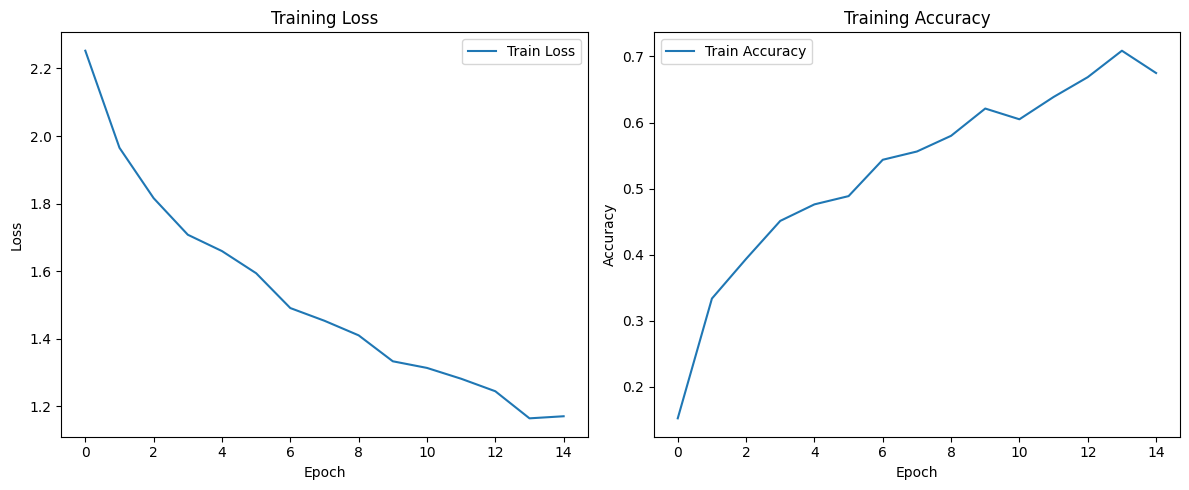

Model saved as 'genre_classifier_waveform.pth'
Evaluating model...


Testing:   0%|          | 0/13 [00:00<?, ?it/s]

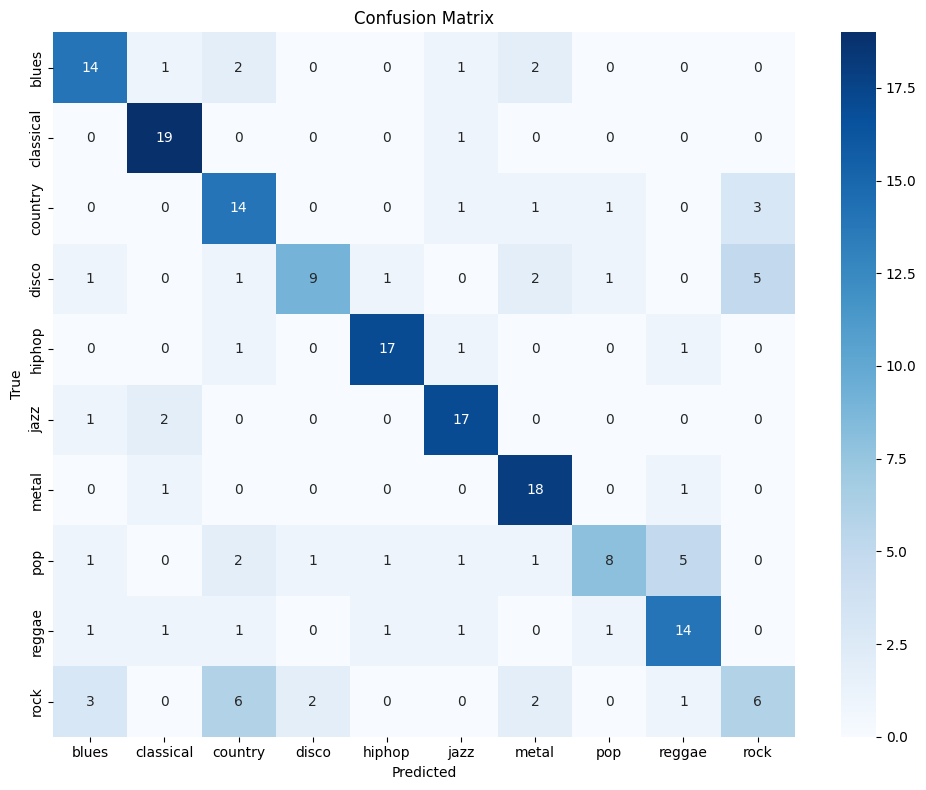

              precision    recall  f1-score   support

       blues     0.6667    0.7000    0.6829        20
   classical     0.7917    0.9500    0.8636        20
     country     0.5185    0.7000    0.5957        20
       disco     0.7500    0.4500    0.5625        20
      hiphop     0.8500    0.8500    0.8500        20
        jazz     0.7391    0.8500    0.7907        20
       metal     0.6923    0.9000    0.7826        20
         pop     0.7273    0.4000    0.5161        20
      reggae     0.6364    0.7000    0.6667        20
        rock     0.4286    0.3000    0.3529        20

    accuracy                         0.6800       200
   macro avg     0.6800    0.6800    0.6664       200
weighted avg     0.6800    0.6800    0.6664       200

Overall accuracy: 0.6800
Done!


In [44]:
# Run the main function if executing as script
if __name__ == "__main__":
    main()